In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [3]:
df = pd.read_csv(r"C:\Users\sniks\OneDrive\Desktop\kc_house_data.csv")

In [ ]:
'''Introduce and Handle Missing Data'''
np.random.seed(42)
df.loc[df.sample(frac=0.05).index, 'sqft_lot'] = np.nan

np.random.seed(43)
df.loc[df.sample(frac=0.05).index, 'bathrooms'] = np.nan


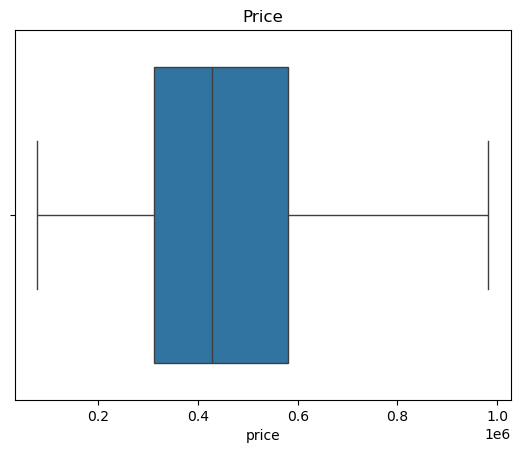

In [ ]:
'''1. Outlier Detection and Handling: '''
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

df = remove_outliers(df, 'price')
df = remove_outliers(df, 'sqft_living')
df = remove_outliers(df, 'bedrooms')

sns.boxplot(x=df['price'])
plt.title('Price')

plt.show()

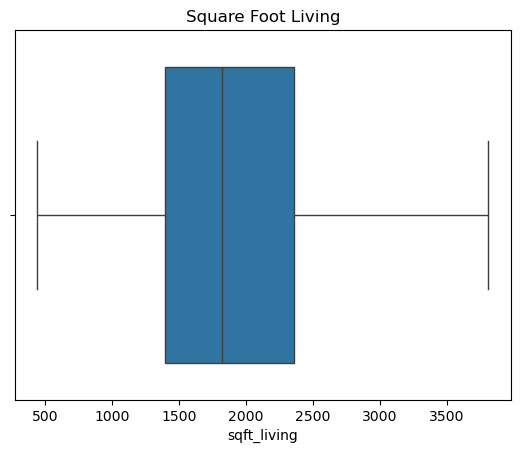

In [17]:
sns.boxplot(x=df['sqft_living'])
plt.title('Square Foot Living')

plt.show()

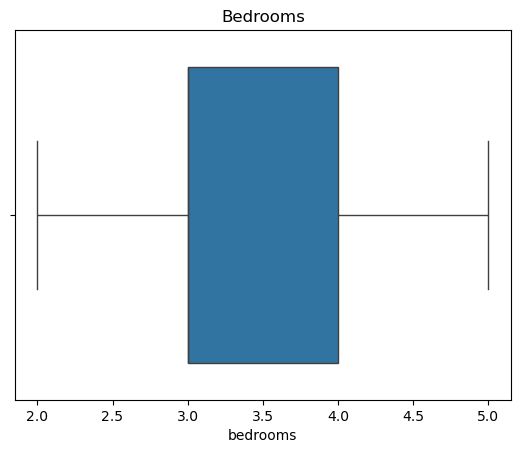

In [18]:
sns.boxplot(x=df['bedrooms'])
plt.title('Bedrooms')

plt.show()

In [ ]:
'''○ Date-Based Features: Do not drop the date column. Convert it to a datetime object and engineer the following:'''
df['date'] = pd.to_datetime(df['date'])
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month
df['house_age'] = df['sale_year'] - df['yr_built']

In [ ]:
'''○ Renovation Status: '''
df['was_renovated'] = (df['yr_renovated'] != 0).astype(int)
df['age_since_renovation'] = df['house_age'] - (df['sale_year'] - df['yr_renovated'])
df['age_since_renovation'] = df['age_since_renovation'].clip(lower=0)

In [ ]:
'''○ Ratio Features: Create at least two insightful ratio features. For example: '''
df['sqft_living_per_floor'] = df['sqft_living'] / df['floors'].replace(0, np.nan)
df['bath_per_bed'] = df['bathrooms'] / df['bedrooms'].replace(0, np.nan)

In [ ]:
'''Task 2: Build a Sophisticated Preprocessing Pipeline  '''
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numerical_features = ['sqft_living', 'house_age', 'sqft_lot', 'bathrooms', 'bedrooms', 'sqft_living_per_floor', 'bath_per_bed', 'age_since_renovation']
categorical_features = ['zipcode']
passthrough_features = ['grade', 'condition', 'was_renovated']
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),    
    ('scaler', StandardScaler())            
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))      
])
passthrough_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  
])
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numerical_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features),
    ('passthrough', passthrough_pipeline, passthrough_features)
])
X = df.drop(columns=['price', 'id', 'date', 'yr_built', 'yr_renovated'])
y = df['price']
X_processed = preprocessor.fit_transform(X)
print(X_processed)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 212505 stored elements and shape (19257, 81)>
  Coords	Values
  (0, 0)	-1.0743503520797941
  (0, 1)	0.533863042538026
  (0, 2)	-0.22610850787085635
  (0, 3)	-1.6038980882650353
  (0, 4)	-0.3683531727180211
  (0, 5)	-0.40464295602915257
  (0, 6)	-1.5396868161015655
  (0, 7)	-0.17566425858685308
  (0, 74)	1.0
  (0, 78)	7.0
  (0, 79)	3.0
  (1, 0)	0.9722164811477495
  (1, 1)	0.6720324798483784
  (1, 2)	-0.17794553767005686
  (1, 3)	-0.01842188813312133
  (1, 4)	-0.3683531727180211
  (1, 5)	-0.21978775778229254
  (1, 6)	0.0025078009485035896
  (1, 7)	3.3317015389786926
  (1, 63)	1.0
  (1, 78)	7.0
  (1, 79)	3.0
  (1, 80)	1.0
  (2, 0)	-1.678013950369933
  (2, 1)	1.328337307072553
  :	:
  (19254, 67)	1.0
  (19254, 78)	7.0
  (19254, 79)	3.0
  (19255, 0)	-0.4559632513923349
  (19255, 1)	-1.1241702051862044
  (19255, 2)	-0.17089656024745242
  (19255, 3)	0.7743162119328356
  (19255, 4)	-0.3683531727180211
  (19255, 5)	-1.073642721113027

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
'''1. Select Candidate Models: Based on the results from the original notebook, choose the top 3 performing models (e.g., Gradient Boosting, XGBoost, Random Forest). '''
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
], memory='cache_dir')

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
], memory='cache_dir')

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
], memory='cache_dir')


In [ ]:
'''2. Hyperparameter Tuning with GridSearchCV: '''
rf_param_grid = {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [None, 10, 20]}
gb_param_grid = {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.1, 0.05], 'regressor__max_depth': [3, 5]} 
xgb_param_grid = {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.1, 0.05], 'regressor__max_depth': [3, 5]}   

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=2)
gb_grid = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=2)
xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=2)


In [63]:
rf_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(memory='cache_dir',
                                steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['sqft_living',
                                                                          'house_age',
                                                                          'sqft_lot',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'sqft_living_per_floor',
                                                                          'bath_per_bed',
                                                                          'age_since_renovation']),
                                                                        ('cat',
                                                                         Pipeline(...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=2,
             param_grid={'regressor__learning_rate': [0.1, 0.05],
                         'regressor__max_depth': [3, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [ ]:
'''1. Final Evaluation: '''
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

best_model = xgb_grid.best_estimator_  
y_pred = best_model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2: 0.8150665840916256
MAE: 59274.78561867212
RMSE: 82390.68120006572


In [ ]:
'''2. Performance Comparison: '''
original_model = XGBRegressor(random_state=42)
original_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', original_model)
])
original_pipeline.fit(X_train, y_train)

y_pred_orig = original_pipeline.predict(X_test)
rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred_orig))
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred))


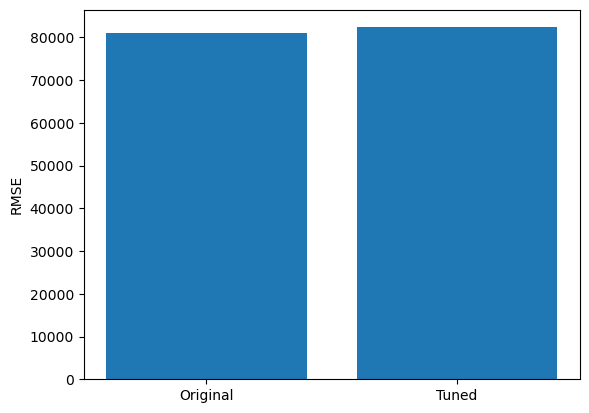

In [108]:
plt.bar(['Original', 'Tuned'], [rmse_orig, rmse_tuned])
plt.ylabel('RMSE')
plt.show()

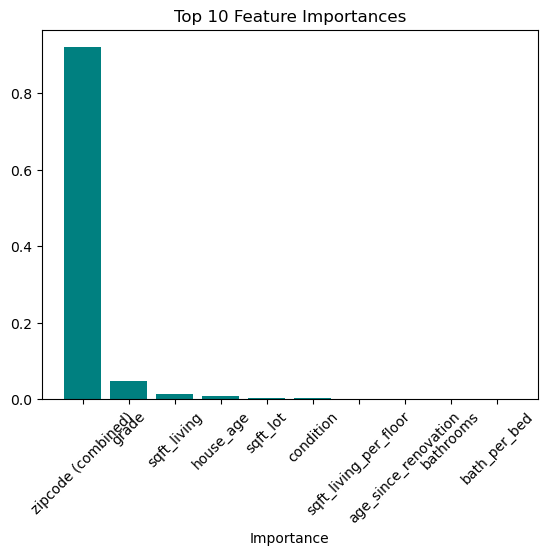

In [ ]:
'''3. Feature Importance: '''
import pandas as pd
import matplotlib.pyplot as plt

importances = best_model.named_steps['regressor'].feature_importances_

encoded_cat = preprocessor.named_transformers_['cat'].named_steps['onehot']
encoded_cat_names = encoded_cat.get_feature_names_out(categorical_features).tolist()
all_feature_names = numerical_features + encoded_cat_names + passthrough_features

feat_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})

zipcode_rows = feat_df[feat_df['Feature'].str.startswith('zipcode_')]
zipcode_total = zipcode_rows['Importance'].sum()

filtered_df = feat_df[~feat_df['Feature'].str.startswith('zipcode_')].copy()
filtered_df.loc[len(filtered_df)] = ['zipcode (combined)', zipcode_total]

top10 = filtered_df.sort_values(by='Importance', ascending=False).head(10)
plt.bar(top10['Feature'], top10['Importance'], color='teal')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [ ]:
'''Top 5 features of xgboost model prediction.  1: zipcode that is location matters. 2: grade that is quality is important. 3: sqrt_living that is size is also important for price prediction. 4: House age affects which also plays a role and lastly sqt_lot '''